In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

import seaborn as sns
sns.set_style('white')

In [2]:
import os
from tqdm import tqdm
from glob import glob
import pickle
from collections import defaultdict

import skimage
import numpy as np
import pandas as pd
import scipy
import numpy_indexed as npi

import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics

import cv2

In [3]:
import torch
from torch.utils.data.sampler import Sampler
import torch.nn.functional as F

import torchvision.models as models

In [4]:
import sys

sys.path.append('..')
import src.utils.dataset as ds
from src.utils.visualisation import *
from src.configs.config import *
from src.configs import config
from src.utils import learner as lrn
from src.utils import lr_finder as lrf
from src.utils import augmentations as augs
from src.utils import visualisation
# from src.modules import wider_resnet

%load_ext autoreload
%autoreload 2
# # import losses
# # import metrics


In [5]:
CUDA_IDX = 0
torch.cuda.set_device(CUDA_IDX)

In [6]:
labels.head(1)

Id   Target  Nucleoplasm  \
0  00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [16, 0]            1   

   Nuclear membrane  Nucleoli  Nucleoli fibrillar center  Nuclear speckles  \
0                 0         0                          0                 0   

   Nuclear bodies  Endoplasmic reticulum  Golgi apparatus      ...       \
0               0                      0                0      ...        

   Microtubule organizing center  Centrosome  Lipid droplets  Plasma membrane  \
0                              0           0               0                0   

   Cell junctions  Mitochondria  Aggresome  Cytosol  Cytoplasmic bodies  \
0               0             0          0        0                   0   

   Rods & rings  
0             0  

[1 rows x 30 columns]

In [7]:
folds = ds.get_folds(PARAMS['NB_FOLDS'], PARAMS['SEED'])
for key in appearance.keys():
    print(key)
    print(
        labels.loc[folds[0][0], key].sum() / len(labels.loc[folds[0][0]]), 
        labels.loc[folds[0][1], key].sum() / len(labels.loc[folds[0][1]]),
        '\n'
    )

Nucleoplasm
0.39672587034656454 0.398836050962093 

Nuclear membrane
0.02779599653697825 0.02752582184239501 

Nucleoli
0.0954167431854553 0.09589472028521995 

Nucleoli fibrillar center
0.033174174252957996 0.03350285744245792 

Nuclear speckles
0.049085709788283444 0.04860273685314319 

Nuclear bodies
0.05104021827531023 0.0512766738321187 

Endoplasmic reticulum
0.03376446205105334 0.03402715881088449 

Golgi apparatus
0.07703911640475379 0.07696744088502071 

Peroxisomes
0.0019151559671537633 0.001939915063178315 

Endosomes
0.0013773381955557887 0.0014680438315944004 

Lysosomes
0.0012068106094393577 0.001258323284223772 

Intermediate filaments
0.018967914578796864 0.018769988989671263 

Actin filaments
0.017131463651389144 0.017197084884391547 

Focal adhesion sites
0.011228585670435763 0.011272479421171289 

Microtubules
0.024700264973633812 0.024694594452891523 

Microtubule ends
0.0004066427053545662 0.00041944109474125726 

Cytokinetic bridge
0.009064197077419523 0.009070413

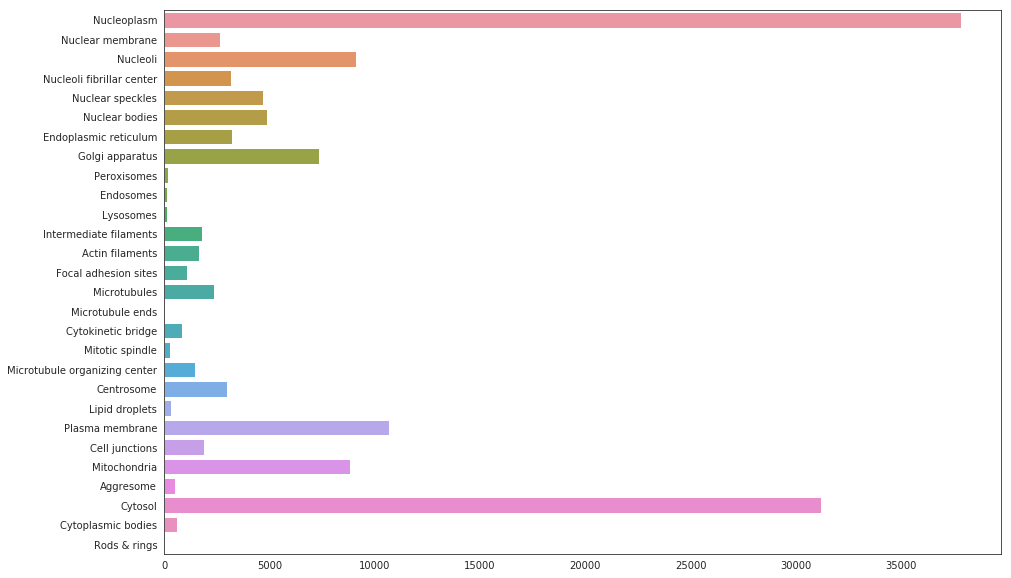

In [8]:
keys = list(config.appearance.keys())
values = np.array(list(config.appearance.values()))

plt.figure(figsize=(15, 10))
sns.barplot(y=keys, x=values);
plt.show()

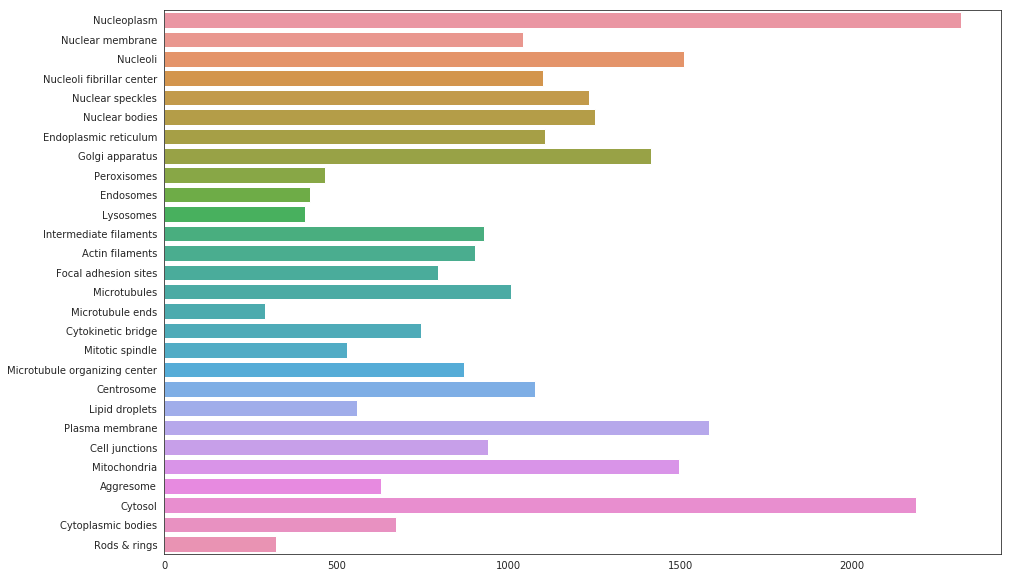

In [9]:
amounts = values * np.power(config.PARAMS['SUPPORT_CLASS_AMOUNT'] / values, config.PARAMS['SUPPORT_POWER'])
amounts = amounts.astype(np.int)

plt.figure(figsize=(15, 10))
sns.barplot(y=keys, x=amounts);
plt.show()

In [10]:
class FocalLoss(torch.nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [11]:
import os


def create_dir(path):
    try:
        os.mkdir(path)
        print('Directory created: {}'.format(path))
    except:
        print('Directory exists: {}'.format(path))


def init_history(path):
        if os.path.isfile(path):
            return pickle.load(open(path, 'rb'))
        else:
            return defaultdict(list)


def format_predictions(results):
    predictions = np.concatenate([r['prediction'] for r in results])
#     predictions = torch.sigmoid(torch.tensor(predictions))
    labels = np.concatenate([r['label'] for r in results])
    loss = np.concatenate([r['loss'].reshape(1) for r in results])
    f1_score = measure_f1(predictions, labels)
    return {
        'predictions': predictions,
        'labels': labels,
        'loss': loss,
        'f1_score': f1_score,
    }

def prepare_data(datagen, nb_samples=PARAMS['NB_INFERS']):
    if isinstance(nb_samples, int):
        nb_samples = range(nb_samples)
    data = [datagen.dataset[i] for i in nb_samples]
    data = datagen.collate_fn(data)
    return data


def measure_f1(predictions, labels, threshs=.5):
    if isinstance(threshs, float):
        threshs = [threshs] * labels.shape[-1]
    return [
        sklearn.metrics.f1_score(labels[:, i], predictions[:, i] > threshs[i]) 
        for i, el in enumerate(label_names_list)
    ]


def format_history(history):
    return {
        key: [np.mean([el[key]]) for el in history] 
        for key in PARAMS['PLOT_KEYS']
    }


def plot_losses(formated_train, formated_valid):
    _, axes = plt.subplots(ncols=len(PARAMS['PLOT_KEYS']), figsize=(10 * len(PARAMS['PLOT_KEYS']), 6))

    for i, key in enumerate(PARAMS['PLOT_KEYS']):
        axes[i].plot(formated_valid[key], label='{} valid'.format(key), alpha=0.7, color='C{}'.format(i * 2))
        axes[i].plot(formated_train[key], label='{} trian'.format(key), alpha=0.7, color='C{}'.format(i * 2 + 1))

        axes[i].set_title(key)
        axes[i].legend()
        axes[i].grid()

    plt.show()

In [12]:
class Orchestrate:
    def __init__(self, learner, checkpoints_pth,
                 lr_scheduler=None,
                 fold=0, hard_negative_miner=None,
                 verbose=True, traced_key='loss', augmentations=None):
        self.learner = learner
        self.hard_negative_miner = hard_negative_miner
        self.verbose = verbose
        self.lr_scheduler = lr_scheduler
        self.traced_key = traced_key

        create_dir(checkpoints_pth)
        self.path = os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}'.format(fold, '{}'))
        self.history = init_history(self.path.format('loss'))
        self.last_epoch = len(self.history['train_losses'])

        folds = ds.get_folds(PARAMS['NB_FOLDS'], PARAMS['SEED'])
        train_dataset, valid_dataset = ds.get_datasets(folds, fold, augmentations=augmentations)
        train_datagen, valid_datagen = ds.get_datagens(train_dataset, valid_dataset)
        self.train_datagen, self.valid_datagen = train_datagen, valid_datagen

    def __call__(self, nb_epochs=PARAMS['NB_EPOCHS']):
        for epoch_i in range(self.last_epoch, nb_epochs):
            if hasattr(self.lr_scheduler, 'step'):
                self.lr_scheduler.step()
            self.learner.freeze_encoder(unfreeze=(epoch_i >= PARAMS['NB_FREEZED_EPOCHS']))

            self.iteration(epoch_i)
            self.checkpoint(epoch_i)

    def iteration(self, epoch_i):
        meters = self.learner.train_on_epoch(
            self.train_datagen, 
            hard_negative_miner=self.hard_negative_miner,
            lr_scheduler=self.lr_scheduler
        )
        meters = format_predictions(meters)
        self.history['train_losses'].append(meters)

        meters = self.learner.validate(self.valid_datagen)
        meters = format_predictions(meters)
        self.history['valid_losses'].append(meters)

        clear_output(wait=True)

    def checkpoint(self, epoch_i):
        if self.verbose:
            plt.figure(figsize=(15,10))
            sns.barplot(y=label_names_list, x=self.history['valid_losses'][-1]['f1_score']);
            plt.show()
            
            formated_train = format_history(self.history['train_losses'])
            formated_valid = format_history(self.history['valid_losses'])
            plot_losses(formated_train, formated_valid)
            data = prepare_data(self.valid_datagen, PARAMS['NB_INFERS'])
            self.learner.infer_on_data(data)

        trace = formated_valid[self.traced_key]
        if trace[-1] >= max(trace):
            state_dict = self.learner.save(self.path.format('best'))
        if epoch_i == (PARAMS['NB_EPOCHS'] - 1):
            state_dict = self.learner.save(self.path.format(epoch_i))

        pickle.dump(self.history, open(self.path.format('loss'), 'wb'))


In [13]:
loss = FocalLoss(gamma=2)
augmentations = augs.Augmentation(side=PARAMS['SIDE'], simplex_noise=PARAMS['SIMPLEX_NOISE'])

# SIDE == 384

In [14]:
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
from collections import OrderedDict

__all__ = ['DenseNet', 'densenet121', 'densenet169', 'densenet201', 'densenet161']


model_urls = {
    'densenet121': 'https://download.pytorch.org/models/densenet121-a639ec97.pth',
    'densenet169': 'https://download.pytorch.org/models/densenet169-b2777c0a.pth',
    'densenet201': 'https://download.pytorch.org/models/densenet201-c1103571.pth',
    'densenet161': 'https://download.pytorch.org/models/densenet161-8d451a50.pth',
}


class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                        growth_rate, kernel_size=1, stride=1, bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                        kernel_size=3, stride=1, padding=1, bias=False)),
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = super(_DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)


class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, drop_rate)
            self.add_module('denselayer%d' % (i + 1), layer)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class DenseNet(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_
    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
    """

    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=1000):

        super(DenseNet, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)
        self.global_pooling_do = lrn.GlobalPooling(dropout=PARAMS['DROPOUT'])

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
#         out = F.adaptive_avg_pool2d(out, (1, 1)).view(features.size(0), -1)
        out = self.global_pooling_do(out)
        out = self.classifier(out)
        return out


def densenet121(pretrained=False, **kwargs):
    r"""Densenet-121 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = DenseNet(num_init_features=64, growth_rate=32, block_config=(6, 12, 24, 16),
                     **kwargs)
    if pretrained:
        # '.'s are no longer allowed in module names, but pervious _DenseLayer
        # has keys 'norm.1', 'relu.1', 'conv.1', 'norm.2', 'relu.2', 'conv.2'.
        # They are also in the checkpoints in model_urls. This pattern is used
        # to find such keys.
        pattern = re.compile(
            r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')
        state_dict = model_zoo.load_url(model_urls['densenet121'])
        for key in list(state_dict.keys()):
            res = pattern.match(key)
            if res:
                new_key = res.group(1) + res.group(2)
                state_dict[new_key] = state_dict[key]
                del state_dict[key]
        model.load_state_dict(state_dict)
    return model


def densenet169(pretrained=False, **kwargs):
    r"""Densenet-169 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = DenseNet(num_init_features=64, growth_rate=32, block_config=(6, 12, 32, 32),
                     **kwargs)
    if pretrained:
        # '.'s are no longer allowed in module names, but pervious _DenseLayer
        # has keys 'norm.1', 'relu.1', 'conv.1', 'norm.2', 'relu.2', 'conv.2'.
        # They are also in the checkpoints in model_urls. This pattern is used
        # to find such keys.
        pattern = re.compile(
            r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')
        state_dict = model_zoo.load_url(model_urls['densenet169'])
        for key in list(state_dict.keys()):
            res = pattern.match(key)
            if res:
                new_key = res.group(1) + res.group(2)
                state_dict[new_key] = state_dict[key]
                del state_dict[key]
        model.load_state_dict(state_dict)
    return model


def densenet201(pretrained=False, **kwargs):
    r"""Densenet-201 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = DenseNet(num_init_features=64, growth_rate=32, block_config=(6, 12, 48, 32),
                     **kwargs)
    if pretrained:
        # '.'s are no longer allowed in module names, but pervious _DenseLayer
        # has keys 'norm.1', 'relu.1', 'conv.1', 'norm.2', 'relu.2', 'conv.2'.
        # They are also in the checkpoints in model_urls. This pattern is used
        # to find such keys.
        pattern = re.compile(
            r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')
        state_dict = model_zoo.load_url(model_urls['densenet201'])
        for key in list(state_dict.keys()):
            res = pattern.match(key)
            if res:
                new_key = res.group(1) + res.group(2)
                state_dict[new_key] = state_dict[key]
                del state_dict[key]
        model.load_state_dict(state_dict)
    return model


def densenet161(pretrained=False, **kwargs):
    r"""Densenet-161 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = DenseNet(num_init_features=96, growth_rate=48, block_config=(6, 12, 36, 24),
                     **kwargs)
    if pretrained:
        # '.'s are no longer allowed in module names, but pervious _DenseLayer
        # has keys 'norm.1', 'relu.1', 'conv.1', 'norm.2', 'relu.2', 'conv.2'.
        # They are also in the checkpoints in model_urls. This pattern is used
        # to find such keys.
        pattern = re.compile(
            r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')
        state_dict = model_zoo.load_url(model_urls['densenet161'])
        for key in list(state_dict.keys()):
            res = pattern.match(key)
            if res:
                new_key = res.group(1) + res.group(2)
                state_dict[new_key] = state_dict[key]
                del state_dict[key]
        model.load_state_dict(state_dict)
    return model

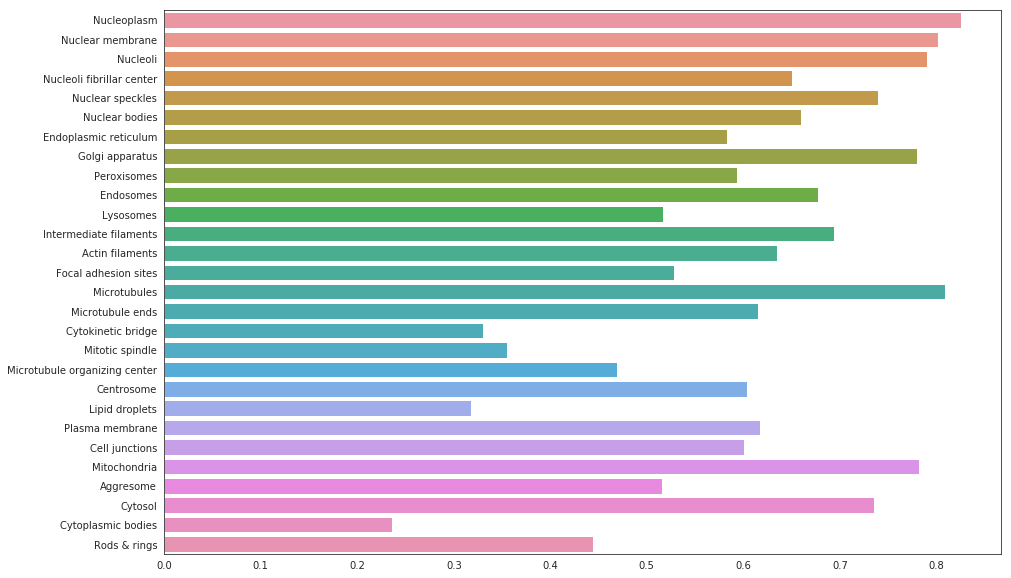

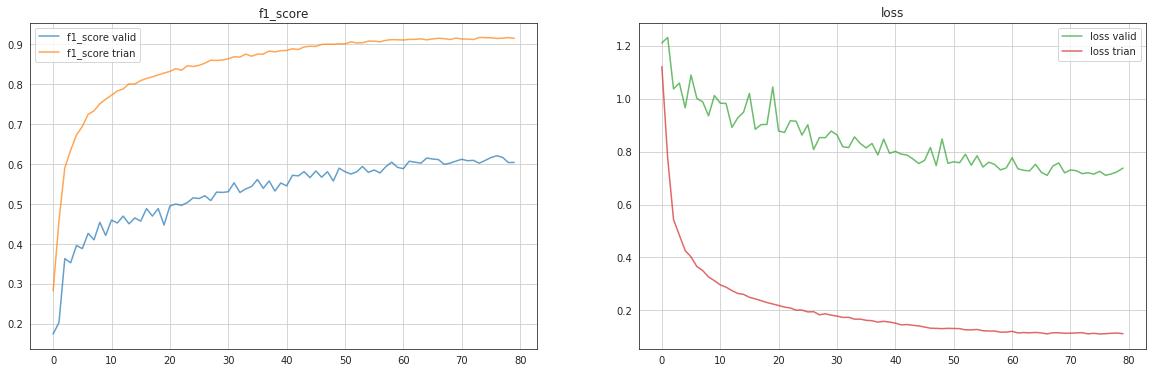

['Nucleoplasm', 'Nuclear membrane', 'Nucleoli', 'Golgi apparatus'] [0.47354612 0.99670875 0.3585435  0.41310307]
['Nucleoplasm', 'Nucleoli'] [0.5843053 0.6725874]
['Mitochondria'] [0.9721362]


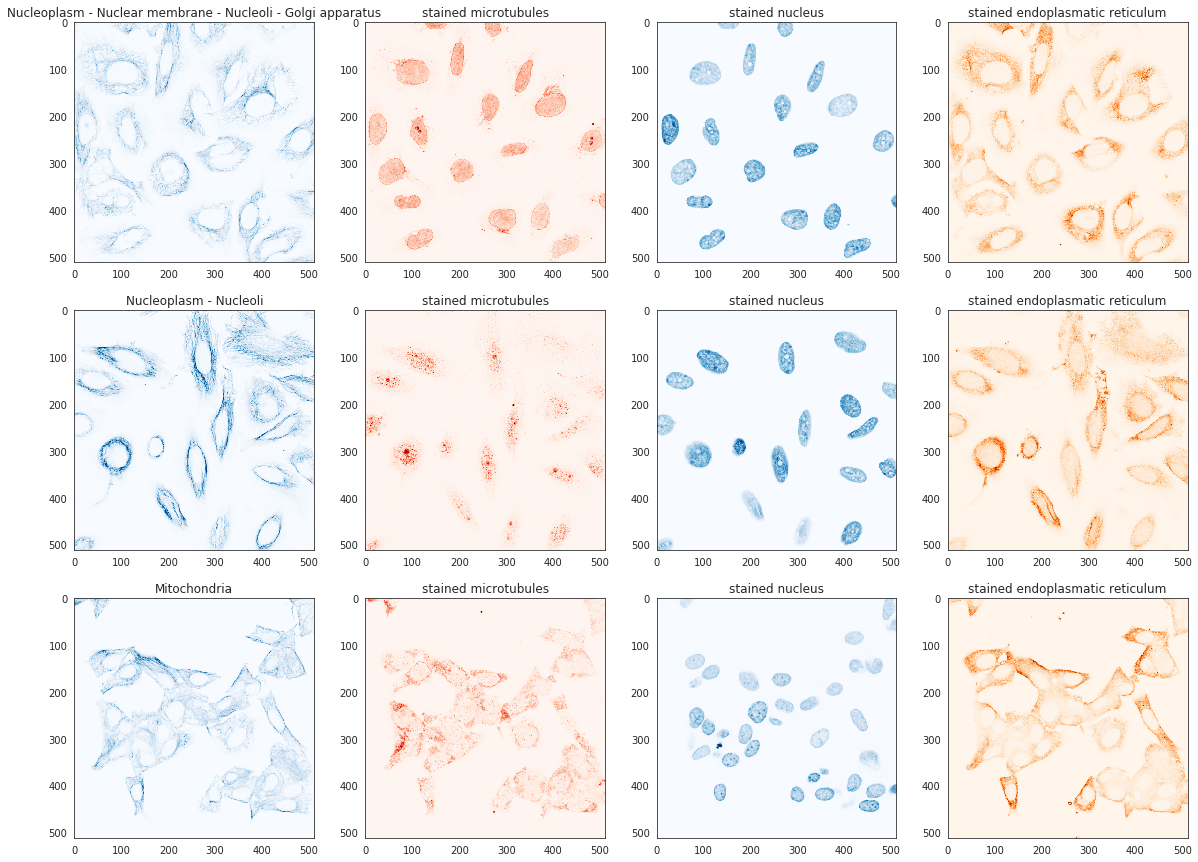

Saved in ../data/models/densnet121_side_512/fold_3_checkpoint.epoch_79:


In [15]:
checkpoints_pth = '../data/models/densnet121_side_512/'
fold = 3

model = densenet121(pretrained=True) # models.resnet50(pretrained=True)
model = lrn.set_io_dims_densnet(model, in_channels=4, out_channels=28, dropout=PARAMS['DROPOUT'])
model = lrn.get_model(model, checkpoint=os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_best'.format(fold)), devices=PARAMS['CUDA_DEVICES'])

opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
learner = lrn.Learner(model=model, opt=opt, loss=loss)

orchestrater = Orchestrate(
    learner, checkpoints_pth=checkpoints_pth, fold=fold, lr_scheduler=None, 
    hard_negative_miner=None, verbose=True, traced_key='f1_score', 
    augmentations=augmentations
)
orchestrater(nb_epochs=PARAMS['NB_FREEZED_EPOCHS'])

coeff = config.PARAMS['EXP_GAMMA'] ** ((1187 * 63) // 800)

lr_scheduler = lrf.Pilo(
    opt, min_lr=coeff * config.PARAMS['MIN_LR'], max_lr=coeff * config.PARAMS['LR'], 
    coeff=config.PARAMS['EXP_GAMMA'], steps_per_epoch=800, 
)

orchestrater = Orchestrate(
    learner, checkpoints_pth=checkpoints_pth, fold=fold, lr_scheduler=lr_scheduler, 
    hard_negative_miner=None, verbose=True, traced_key='f1_score', 
    augmentations=augmentations
)
orchestrater(nb_epochs=PARAMS['NB_EPOCHS'])

In [ ]:
checkpoints_pth = '../data/models/densnet121_side_512/'
fold = 4

model = densenet121(pretrained=True) # models.resnet50(pretrained=True)
model = lrn.set_io_dims_densnet(model, in_channels=4, out_channels=28, dropout=PARAMS['DROPOUT'])
model = lrn.get_model(model, checkpoint=None, devices=PARAMS['CUDA_DEVICES'])

opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
learner = lrn.Learner(model=model, opt=opt, loss=loss)

orchestrater = Orchestrate(
    learner, checkpoints_pth=checkpoints_pth, fold=fold, lr_scheduler=None, 
    hard_negative_miner=None, verbose=True, traced_key='f1_score', 
    augmentations=augmentations
)
orchestrater(nb_epochs=PARAMS['NB_FREEZED_EPOCHS'])

# coeff = config.PARAMS['EXP_GAMMA'] ** ((1187 * 63) // 800)

lr_scheduler = lrf.Pilo(
    opt, min_lr=coeff * config.PARAMS['MIN_LR'], max_lr=coeff * config.PARAMS['LR'], 
    coeff=config.PARAMS['EXP_GAMMA'], steps_per_epoch=800, 
)

orchestrater = Orchestrate(
    learner, checkpoints_pth=checkpoints_pth, fold=fold, lr_scheduler=lr_scheduler, 
    hard_negative_miner=None, verbose=True, traced_key='f1_score', 
    augmentations=augmentations
)
orchestrater(nb_epochs=PARAMS['NB_EPOCHS'])

Directory exists: ../data/models/densnet121_side_512/


  9%|▊         | 177/2059 [01:49<19:27,  1.61it/s]

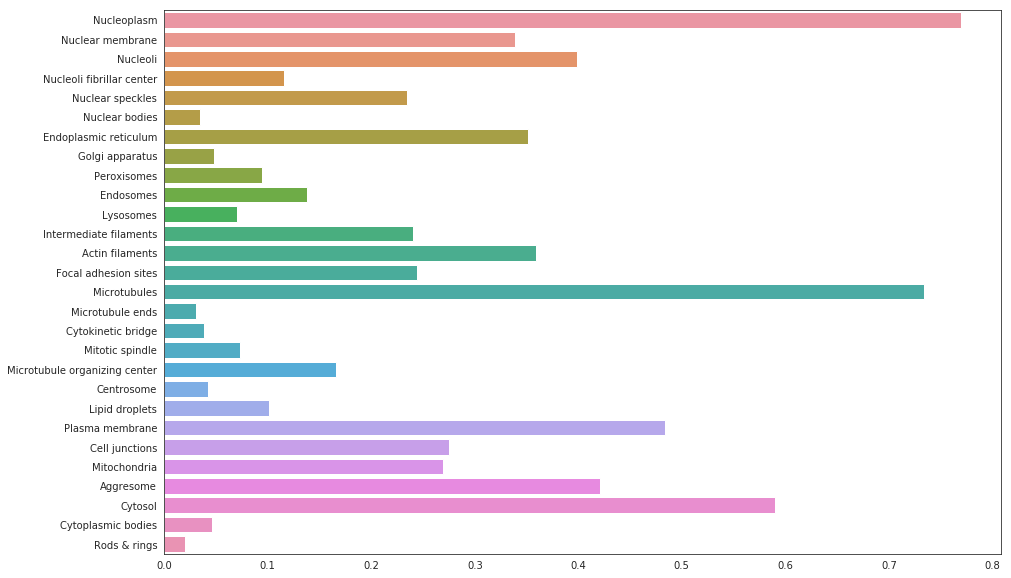

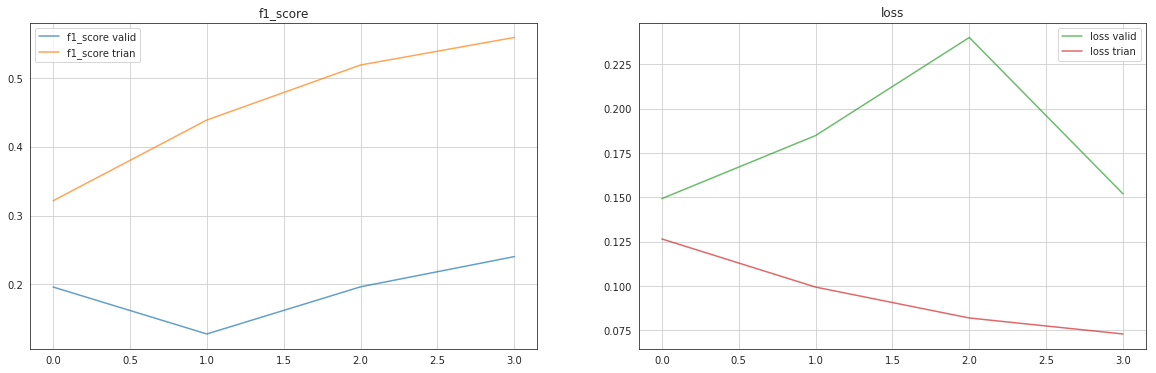

['Nuclear membrane'] [0.440473]
['Nucleoplasm'] [0.73801816]
['Intermediate filaments'] [0.47502005]


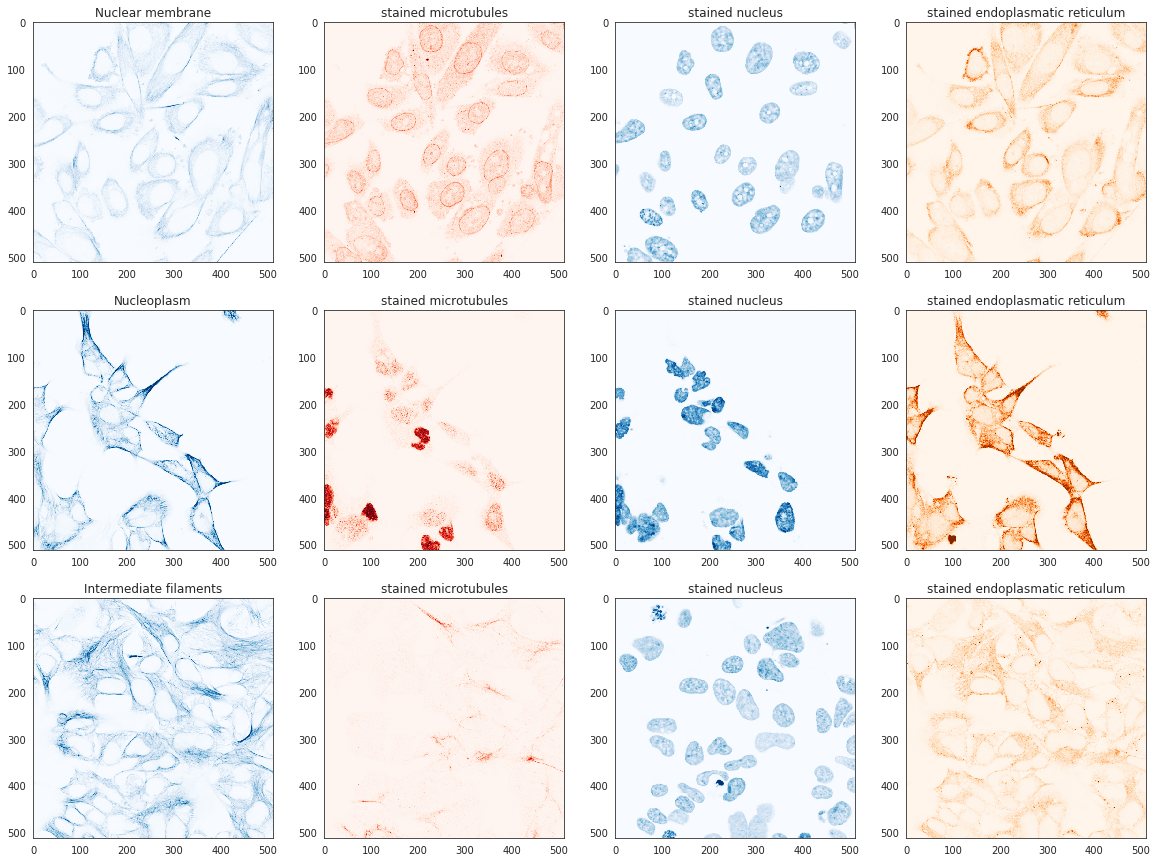

  0%|          | 0/2059 [00:00<?, ?it/s]

Saved in ../data/models/densnet169_side_512/fold_4_checkpoint.epoch_best:


 32%|███▏      | 663/2059 [06:13<13:07,  1.77it/s]

In [ ]:
checkpoints_pth = '../data/models/densnet169_side_512/'
fold = 4
loss = torch.nn.BCEWithLogitsLoss()

model = densenet169(pretrained=True) # models.resnet50(pretrained=True)
model = lrn.set_io_dims_densnet(model, in_channels=4, out_channels=28, dropout=PARAMS['DROPOUT'])
model = lrn.get_model(model, checkpoint=os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_best'.format(fold)), devices=PARAMS['CUDA_DEVICES'])

opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
learner = lrn.Learner(model=model, opt=opt, loss=loss)

orchestrater = Orchestrate(
    learner, checkpoints_pth=checkpoints_pth, fold=fold, lr_scheduler=None, 
    hard_negative_miner=None, verbose=True, traced_key='f1_score', 
    augmentations=augmentations
)
orchestrater(nb_epochs=PARAMS['NB_FREEZED_EPOCHS'])

coeff = 1#config.PARAMS['EXP_GAMMA'] ** ((1187 * 63) // 800)

lr_scheduler = lrf.Pilo(
    opt, min_lr=coeff * config.PARAMS['MIN_LR'], max_lr=coeff * config.PARAMS['LR'], 
    coeff=config.PARAMS['EXP_GAMMA'], steps_per_epoch=2000, 
)

orchestrater = Orchestrate(
    learner, checkpoints_pth=checkpoints_pth, fold=fold, lr_scheduler=lr_scheduler, 
    hard_negative_miner=None, verbose=True, traced_key='f1_score', 
    augmentations=augmentations
)
orchestrater(nb_epochs=PARAMS['NB_EPOCHS'])

In [ ]:
checkpoints_pth = '../data/models/densnet121_side_512/'
fold = 0

model = densenet121(pretrained=True) # models.resnet50(pretrained=True)
model = lrn.set_io_dims_densnet(model, in_channels=4, out_channels=28, dropout=PARAMS['DROPOUT'])
model = lrn.get_model(model, checkpoint=None, devices=PARAMS['CUDA_DEVICES'])

opt = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)
learner = lrn.Learner(model=model, opt=opt, loss=loss)

orchestrater = Orchestrate(
    learner, checkpoints_pth=checkpoints_pth, fold=fold, lr_scheduler=None, 
    hard_negative_miner=None, verbose=True, traced_key='f1_score', 
    augmentations=augmentations
)
orchestrater(nb_epochs=PARAMS['NB_FREEZED_EPOCHS'])

lr_scheduler = lrf.Pilo(
    opt, min_lr=1e-4, max_lr=5e-4, 
    coeff=.95, steps_per_epoch=800, 
)

orchestrater = Orchestrate(
    learner, checkpoints_pth=checkpoints_pth, fold=fold, lr_scheduler=lr_scheduler, 
    hard_negative_miner=None, verbose=True, traced_key='f1_score', 
    augmentations=augmentations
)
orchestrater(nb_epochs=PARAMS['NB_EPOCHS'])

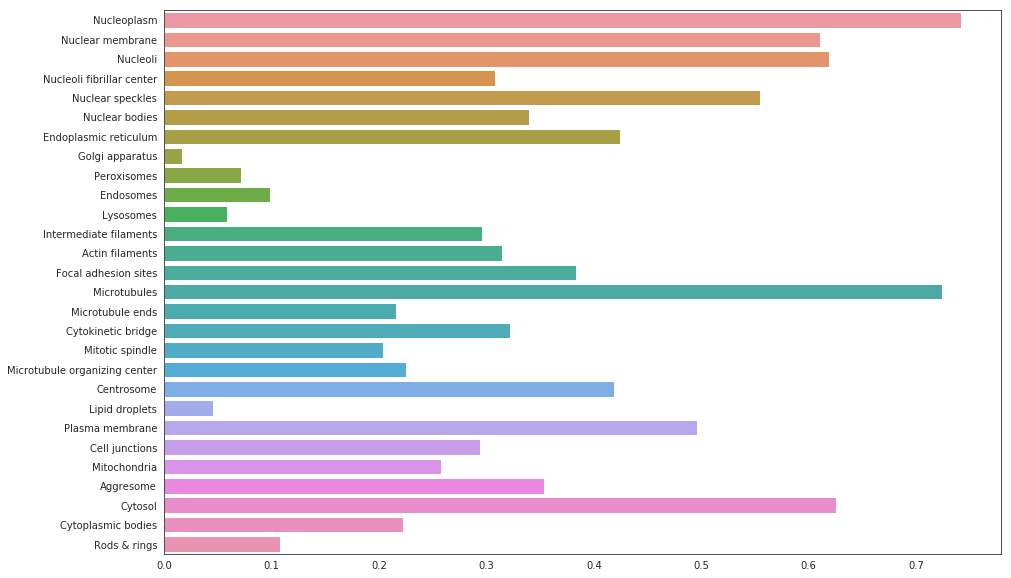

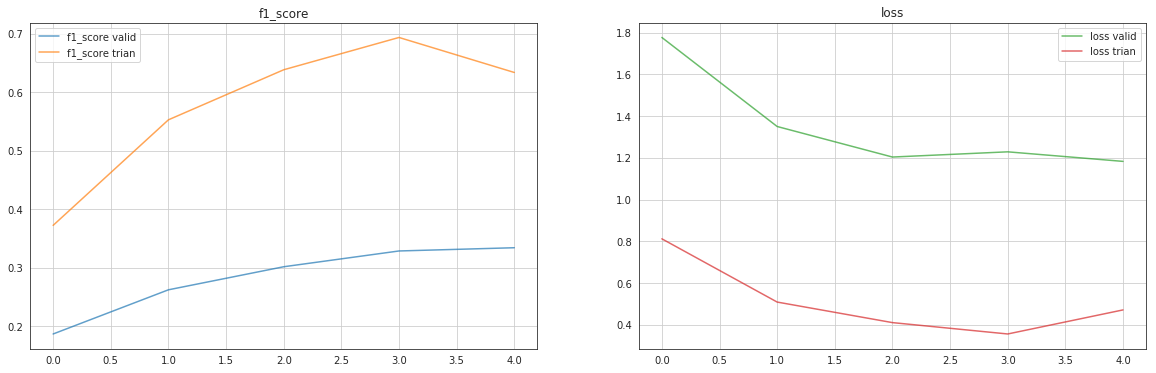

['Nuclear bodies'] [0.44280544]
['Mitochondria'] [0.13290146]
['Plasma membrane'] [0.7167793]


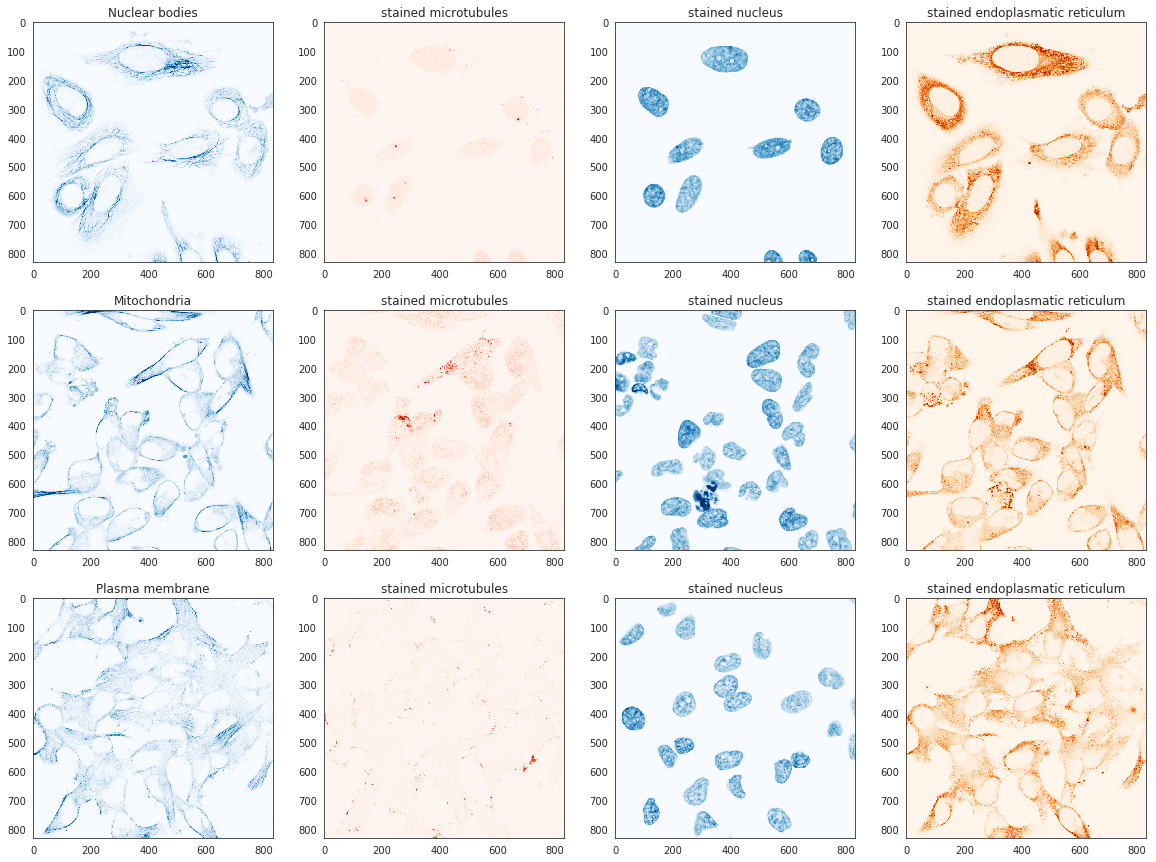

Saved in ../data/models/resnet50_side_768/fold_1_checkpoint.epoch_best:


 23%|██▎       | 489/2166 [11:14<38:31,  1.38s/it]

In [ ]:
checkpoints_pth = '../data/models/resnet50_side_768/'
fold = 1

model = models.resnet50(pretrained=True)
model = lrn.set_io_dims(model, in_channels=4, out_channels=28, dropout=PARAMS['DROPOUT'])
model = lrn.get_model(model, checkpoint=None, devices=PARAMS['CUDA_DEVICES'])

opt = torch.optim.Adam(model.parameters(), lr=4e-4, weight_decay=1e-4)
lr_scheduler = lrf.Pilo(
    opt, min_lr=1e-4, max_lr=5e-4, 
    coeff=.95, steps_per_epoch=1000, 
)
learner = lrn.Learner(model=model, opt=opt, loss=loss)

orchestrater = Orchestrate(
    learner, checkpoints_pth=checkpoints_pth, fold=fold, lr_scheduler=lr_scheduler, 
    hard_negative_miner=None, verbose=True, traced_key='f1_score', 
    augmentations=augmentations
)
orchestrater(nb_epochs=PARAMS['NB_EPOCHS'])

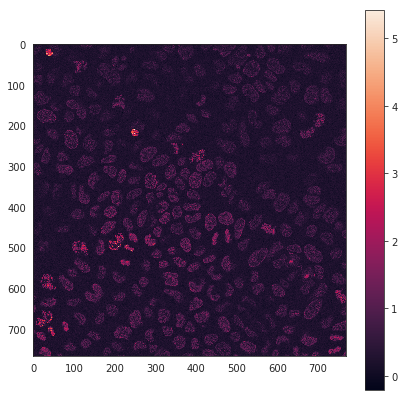

In [84]:
data = orchestrater.train_datagen.dataset[0]
plt.figure(figsize=(7, 7))
a = plt.imshow(data['image'][2])
plt.colorbar(a)

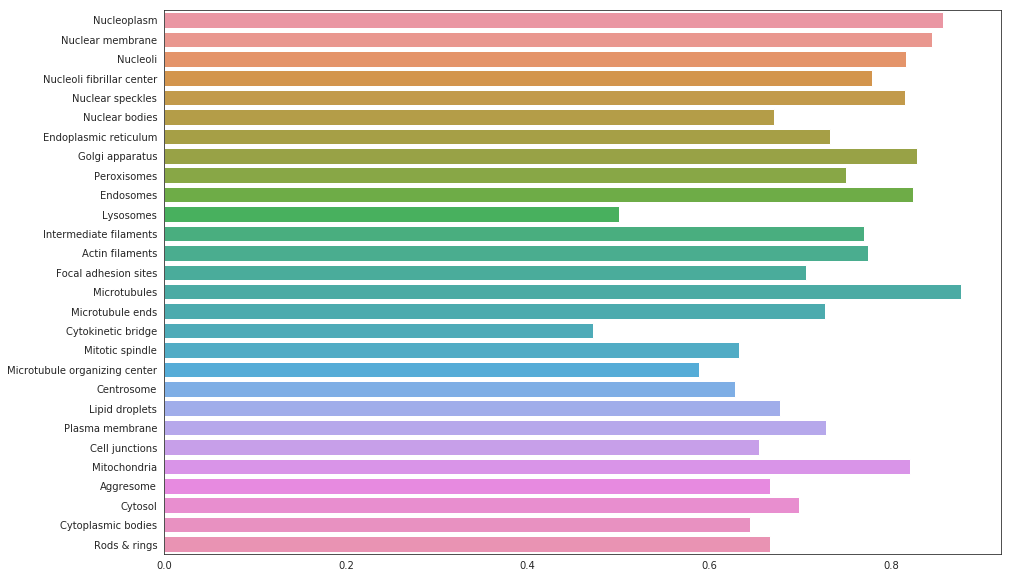

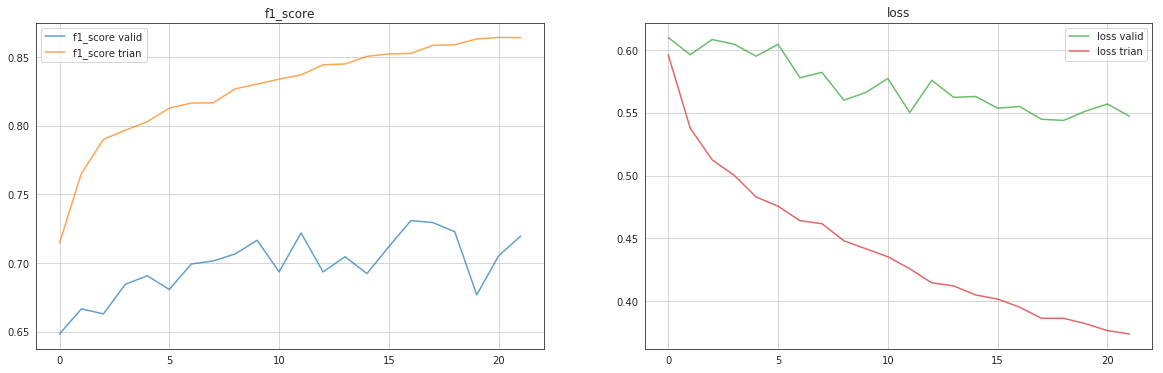

['Nucleoplasm', 'Cytokinetic bridge'] [0.80389184 0.76216364]
['Cytosol'] [0.67353046]
['Focal adhesion sites'] [0.9327711]


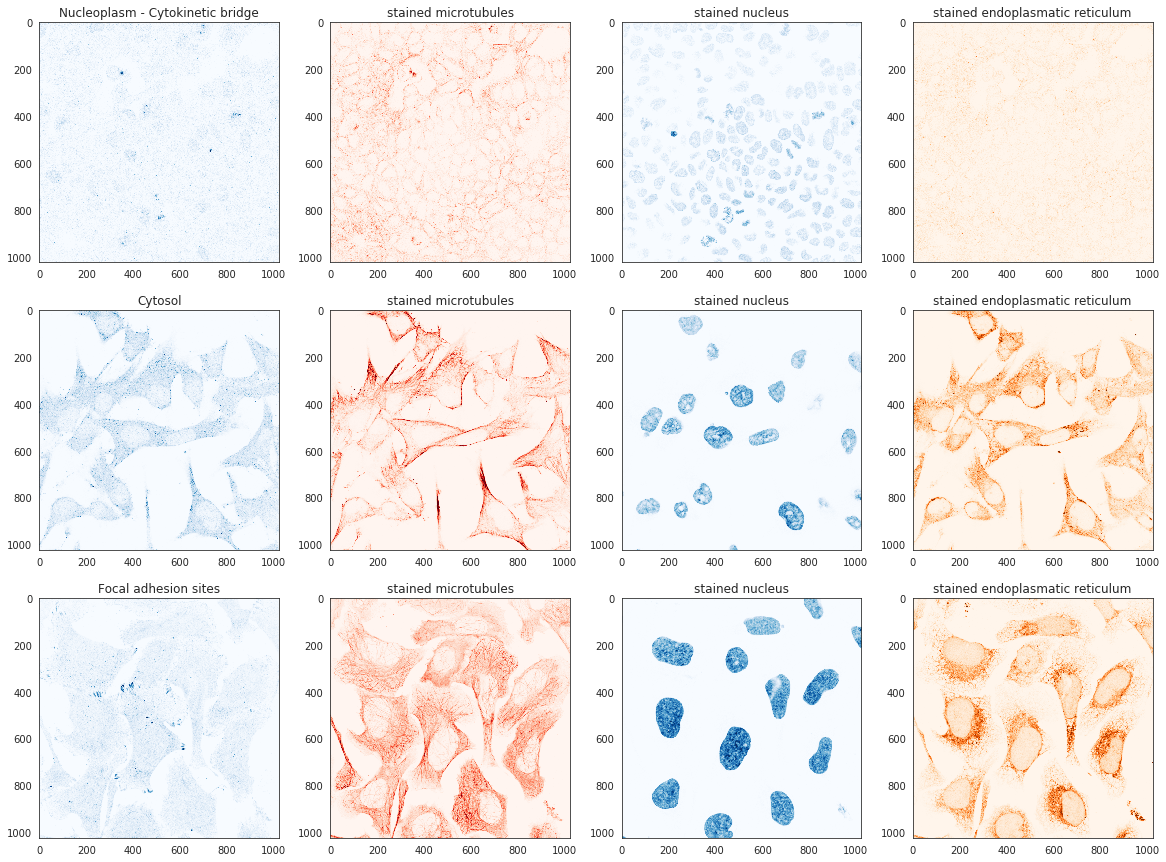

 19%|█▊        | 53/284 [19:14<1:23:51, 21.78s/it]

In [ ]:
checkpoints_pth = '../data/models/resnet101_side_768'
fold = 0

model = models.resnet101(pretrained=True)
model = lrn.set_io_dims(model, in_channels=4, out_channels=28, dropout=PARAMS['DROPOUT'])
model = lrn.get_model(model, checkpoint='../data/models/resnet101_side_384_pilo/fold_{}_checkpoint.epoch_49'.format(fold), devices=PARAMS['CUDA_DEVICES'])

opt = torch.optim.Adam(model.parameters(), lr=4e-4, weight_decay=1e-4)
lr_scheduler = lrf.Pilo(
    opt, min_lr=5e-6, max_lr=1e-5, 
    coeff=.95, steps_per_epoch=1500, 
)
learner = lrn.Learner(model=model, opt=opt, loss=loss)

orchestrater = Orchestrate(
    learner, checkpoints_pth=checkpoints_pth, fold=fold, lr_scheduler=lr_scheduler, 
    hard_negative_miner=None, verbose=True, traced_key='f1_score', 
    augmentations=augmentations
)
orchestrater(nb_epochs=PARAMS['NB_EPOCHS'])

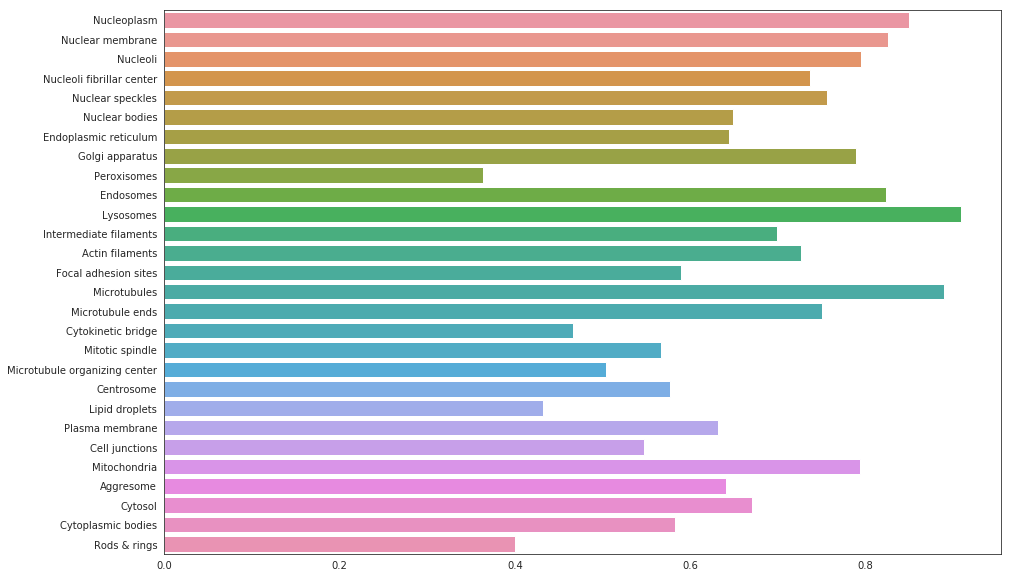

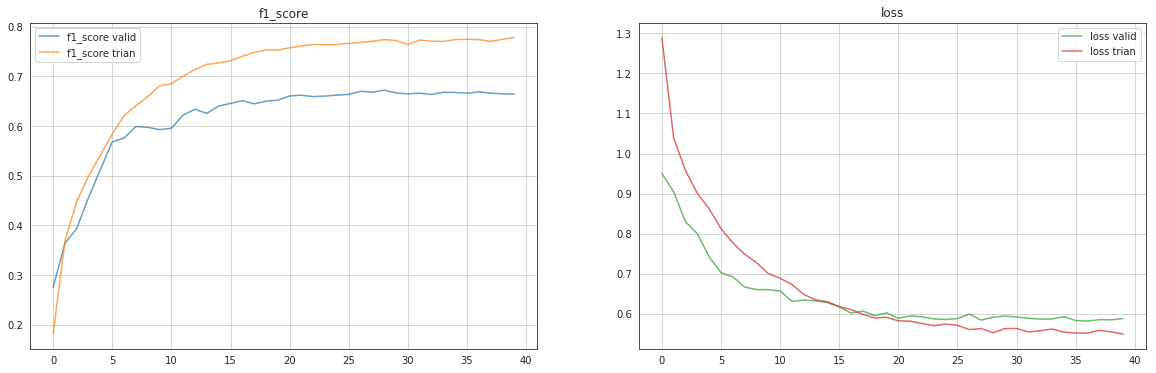

['Nucleoplasm', 'Cytokinetic bridge'] [0.6219584 0.7728585]
['Cytosol'] [0.6919971]
['Focal adhesion sites'] [0.7257887]


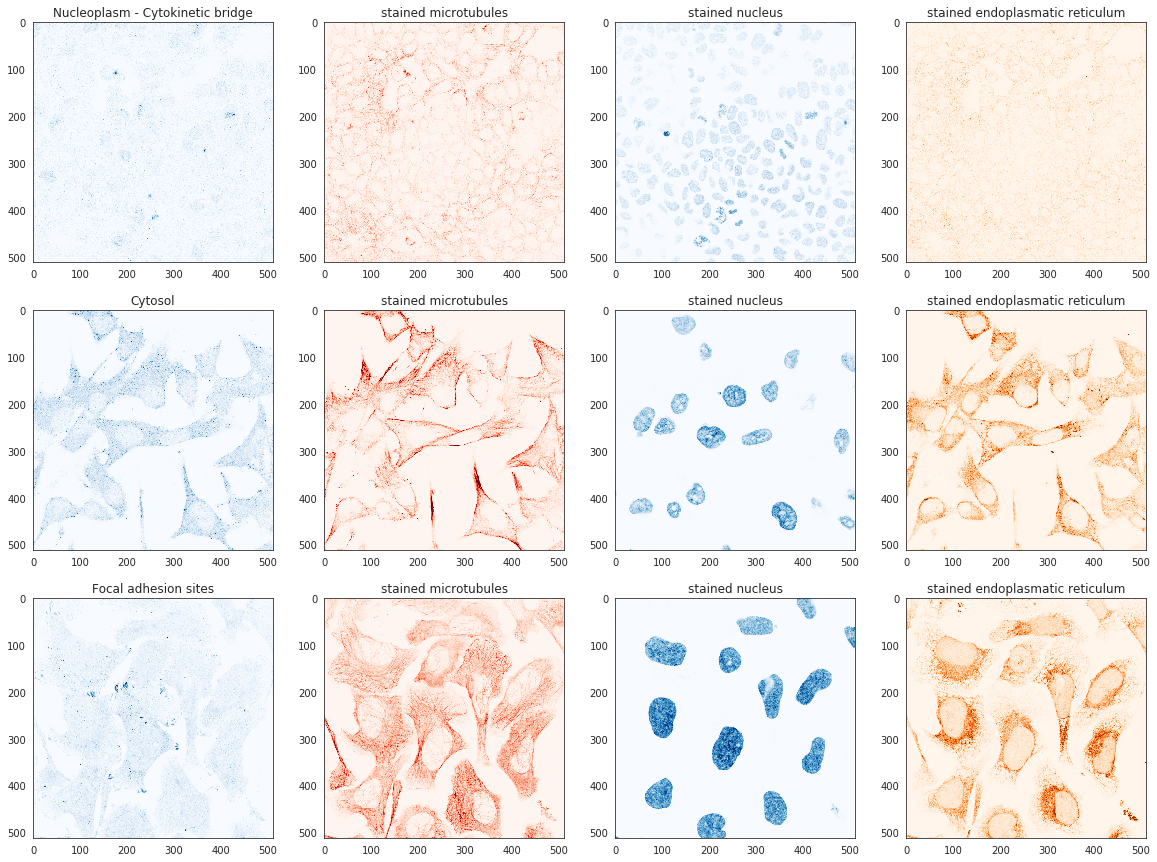

Saved in ../data/models/resnet101_side_384/fold_0_checkpoint.epoch_39:


In [15]:
checkpoints_pth = '../data/models/resnet101_side_384'
fold = 0

model = models.resnet101(pretrained=True)
model = lrn.set_io_dims(model, in_channels=4, out_channels=28, dropout=PARAMS['DROPOUT'])
model = lrn.get_model(model, checkpoint=None, devices=PARAMS['CUDA_DEVICES'])

opt = torch.optim.Adam(model.parameters(), lr=4e-4, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=PARAMS['EXP_GAMMA'], last_epoch=-1)
learner = lrn.Learner(model=model, opt=opt, loss=loss)

orchestrater = Orchestrate(
    learner, checkpoints_pth=checkpoints_pth, fold=fold, lr_scheduler=lr_scheduler, 
    hard_negative_miner=None, verbose=True, traced_key='f1_score', 
    augmentations=augmentations
)
orchestrater(nb_epochs=PARAMS['NB_FREEZED_EPOCHS'])

for param_group in opt.param_groups:
    param_group['lr'] = 5e-5
    param_group['initial_lr'] = 5e-5
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=PARAMS['EXP_GAMMA'], last_epoch=-1)

orchestrater = Orchestrate(
    learner, checkpoints_pth=checkpoints_pth, fold=fold, lr_scheduler=lr_scheduler, 
    hard_negative_miner=None, verbose=True, traced_key='f1_score', 
    augmentations=augmentations
)
orchestrater(nb_epochs=PARAMS['NB_EPOCHS'])

In [15]:
class IncLearner(lrn.Learner):
    def __init__(self, loss_aux, **kwargs):
        super().__init__(**kwargs)
        self.loss_aux = loss_aux

    def make_step(self, data, training=False):
        self.opt.zero_grad()
        image = torch.autograd.Variable(data['image']).cuda(non_blocking=True)
        label = torch.autograd.Variable(data['label']).cuda(non_blocking=True)

        if not training:
            image = augs.get_crops(image, config.PARAMS['SIDE'])
        
        prediction = self.model(image)
        if not training:
            shape = (5, data['image'].shape[0], len(config.label_names_list))
            prediction = prediction.reshape(shape).max(0)[0]
        else:
            prediction, aux = prediction
        loss = self.loss(prediction, label)
        prediction = torch.sigmoid(prediction)

        if training:
            loss += self.loss_aux(aux, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.gclip)
            self.opt.step()

        image = image.data.cpu().numpy()
        return {
            'loss': loss.data.cpu().numpy(), 
            'label': label.data.cpu().numpy(), 
            'prediction': prediction.data.cpu().numpy(),
        }

    def freeze_encoder(self, unfreeze=False):
        if hasattr(self.model, 'module'):
            model_ = self.model.module
        elif hasattr(self.model, 'encoder'):
            model_ = self.model
        encoders = [
        ]
        for encoder in encoders:
            freeze(encoder, unfreeze=unfreeze)
            unfreeze_bn(encoder)

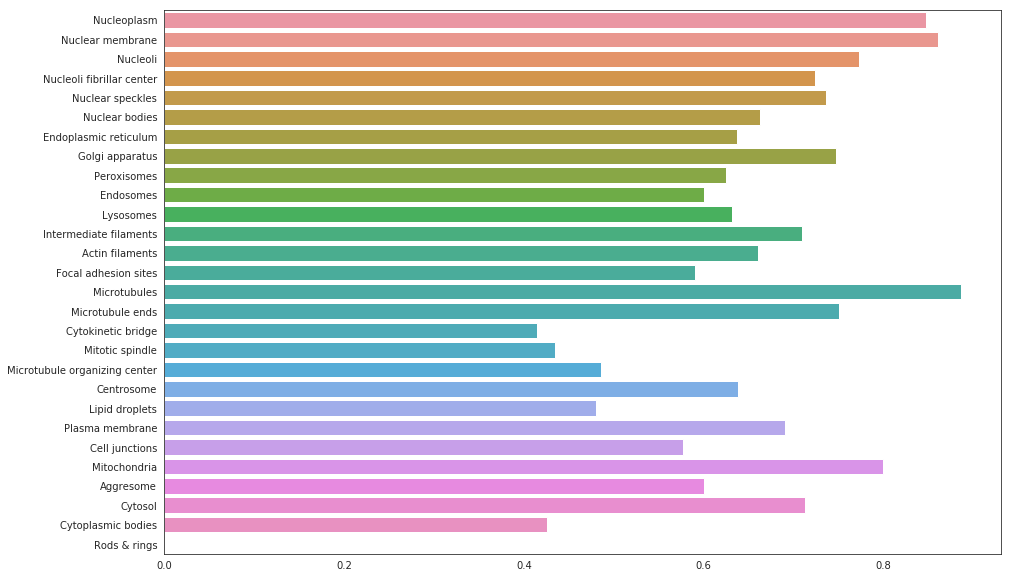

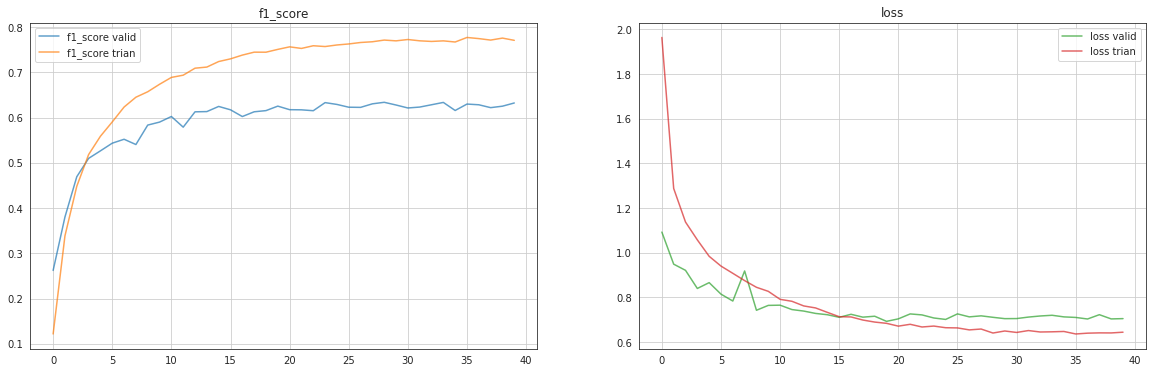

['Nucleoli', 'Endoplasmic reticulum'] [0.981874   0.86545986]
['Nucleoplasm'] [0.93322474]
['Intermediate filaments', 'Cytosol'] [0.75060266 0.37029085]


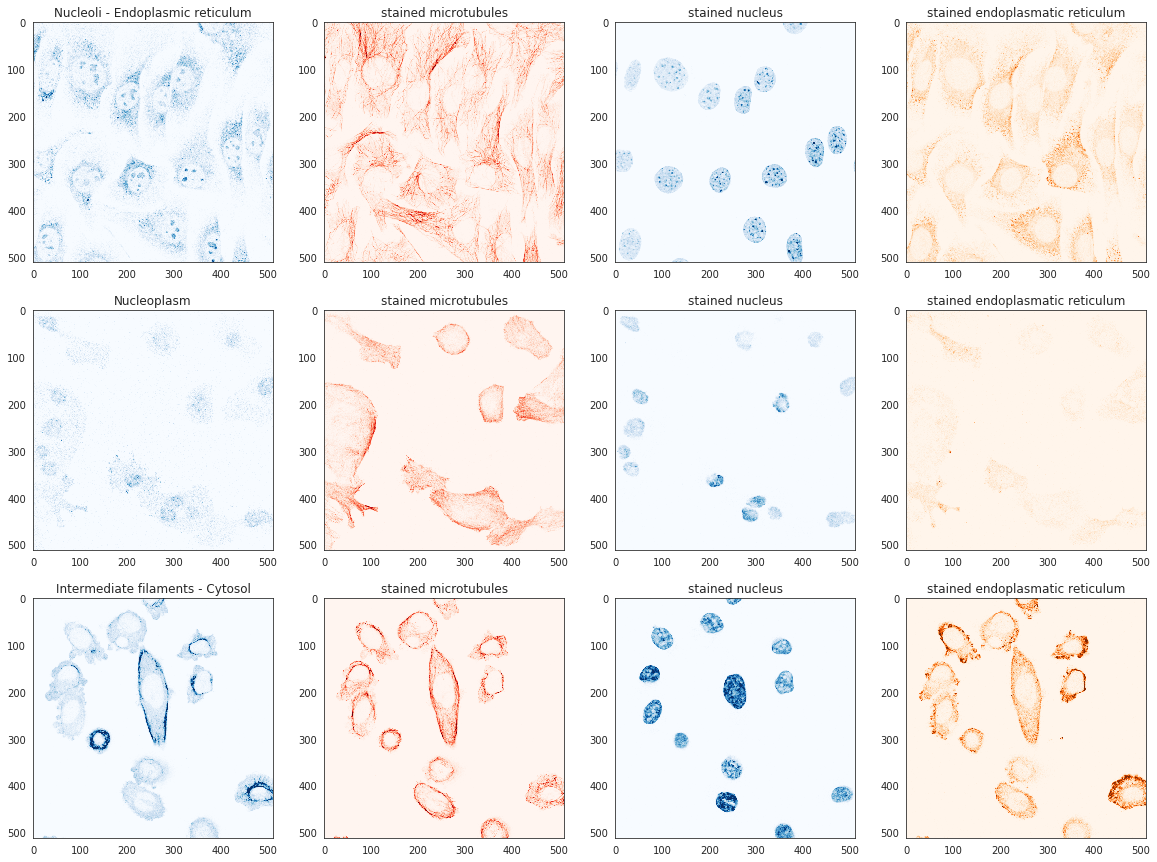

Saved in ../data/models/inception3_side_299/fold_1_checkpoint.epoch_39:


In [18]:
checkpoints_pth = '../data/models/inception3_side_299'
fold = 1

model = models.inception_v3(pretrained=False, num_classes=28)
model_ = models.inception_v3(pretrained=True)

sd = model_.state_dict()
msd = model.state_dict()
sd = {k: v for k, v in sd.items() if (k in msd) and ('fc' not in k)}
print('Overlapped keys: {}'.format(len(sd.keys())))
msd.update(sd)
model.load_state_dict(msd)

model = lrn.set_io_dims_inception(model, in_channels=4)
model = lrn.get_model(model, checkpoint=None, devices=PARAMS['CUDA_DEVICES'])

opt = torch.optim.Adam(model.parameters(), lr=4e-4, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=PARAMS['EXP_GAMMA'], last_epoch=-1)
learner = IncLearner(loss_aux=torch.nn.BCEWithLogitsLoss(), model=model, opt=opt, loss=loss)

orchestrater = Orchestrate(
    learner, checkpoints_pth=checkpoints_pth, fold=fold, lr_scheduler=lr_scheduler, 
    hard_negative_miner=None, verbose=True, traced_key='f1_score', 
    augmentations=augmentations
)
orchestrater(nb_epochs=PARAMS['NB_EPOCHS'])

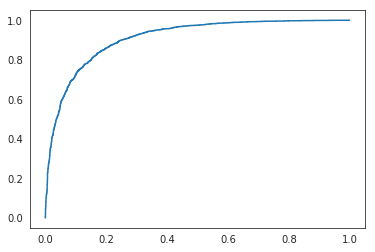

In [18]:
roc_curve = sklearn.metrics.roc_curve(orchestrater.history['valid_losses'][-1]['labels'][:, i], orchestrater.history['valid_losses'][-1]['predictions'][:, i])
plt.plot(roc_curve[0], roc_curve[1])

# Inference

In [15]:
test_df = pd.read_csv(os.path.join(config.PATHS['CSV'], 'sample_submission.csv'))
for name in config.label_names_list + ['Predicted', 'Target']:
    test_df[name] = 0

In [16]:
def prepare_learner(fold, checkpoint):
    model = models.resnet101(pretrained=True)
    model = lrn.set_io_dims(model, in_channels=4, out_channels=28, dropout=PARAMS['DROPOUT'])
    model = lrn.get_model(model, checkpoint=checkpoint, devices=PARAMS['CUDA_DEVICES'])
    model.module.eval()

    loss = FocalLoss(gamma=2)

    opt = torch.optim.Adam(model.parameters(), lr=4e-4, weight_decay=1e-4)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=PARAMS['EXP_GAMMA'], last_epoch=-1)
    learner = lrn.Learner(model=model, opt=opt, loss=loss)
    return learner

def prepare_data(fold):
    folds = ds.get_folds(config.PARAMS['NB_FOLDS'])
    _, valid_dataset = ds.get_datasets(folds, fold)

    test_dataset = ds.ProteinDataset(
        test_df, 
        config.PATHS['TEST'], 
        config.label_names_list, 
        augmentations=None
    )
    return valid_dataset, test_dataset


In [17]:
def infer(model, idx, data, predicts, labels=None):
    with torch.no_grad():
        image = data['image'].unsqueeze(0)
        if config.PARAMS['SIDE'] is not None:
            image = augs.get_crops(image, config.PARAMS['SIDE'])
        image = augs._rotate_mirror_do(image)

        image = torch.tensor(image)
        image = torch.autograd.Variable(image).cuda()
        predict = model(image)
        predict = torch.sigmoid(predict)
        predict = predict.reshape(8, 5, len(config.label_names_list))
        predicts[idx] = predict.mean(0).data.cpu().numpy()

        image = image.data.cpu()
        if labels is not None:
            labels[idx] = data['label']


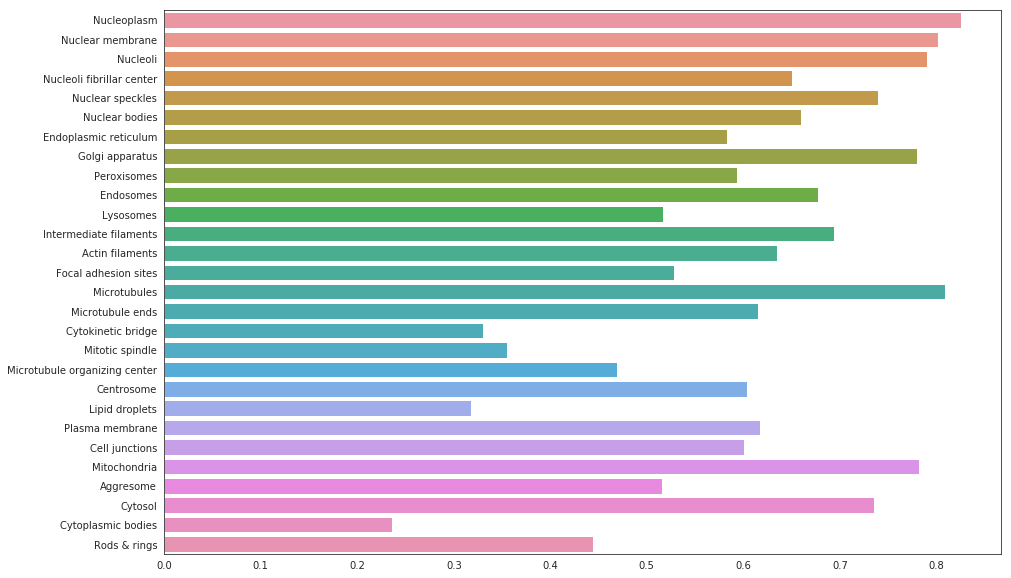

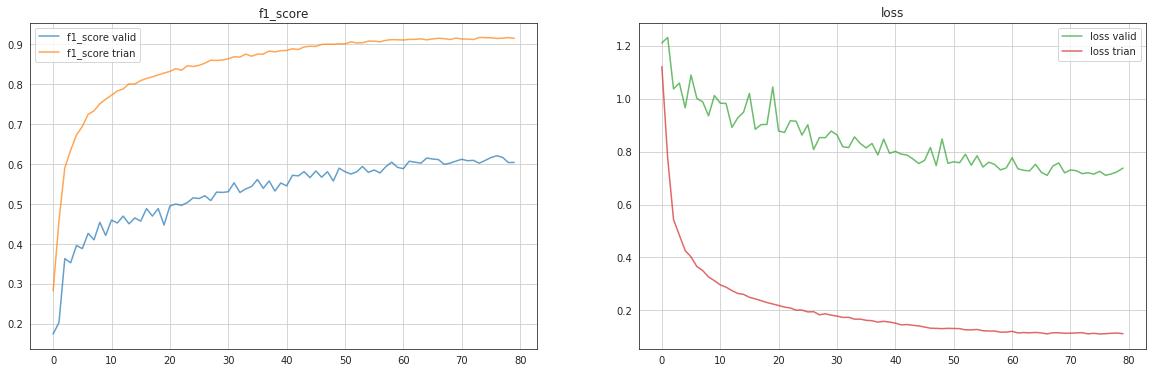

In [18]:
history = pickle.load(open('../data/models/densnet121_side_512/fold_3_checkpoint.epoch_loss', 'rb'))
plt.figure(figsize=(15,10))
sns.barplot(y=label_names_list, x=history['valid_losses'][-1]['f1_score']);
plt.show()

formated_train = format_history(history['train_losses'])
formated_valid = format_history(history['valid_losses'])
plot_losses(formated_train, formated_valid)


In [19]:
def orchestrate_inference(fold, checkpoints_pth, epoch):
    template_path = 'fold_{}_checkpoint.epoch_{}'
    path = os.path.join(checkpoints_pth, template_path)
    dump_path = os.path.join(checkpoints_pth, '{}_fold_{}')
    
    history = pickle.load(open(path.format(fold, 'loss'), 'rb'))
    plt.figure(figsize=(15,10))
    sns.barplot(
        y=label_names_list, 
        x=history['valid_losses'][epoch if isinstance(epoch, int) else -1]['f1_score']
    );
    plt.show()

    formated_train = format_history(history['train_losses'])
    formated_valid = format_history(history['valid_losses'])
    plot_losses(formated_train, formated_valid)
    
    learner = prepare_learner(fold, path.format(fold, epoch))
    valid_dataset, test_dataset = prepare_data(fold)
    

    predicts = np.zeros(shape=(len(test_dataset), 5, len(config.label_names_list)))
    try:
        for idx in tqdm(range(len(test_dataset))):
            infer(learner.model, idx, test_dataset[idx], predicts, labels=None)
    except Exception as e:
        print(e)
        print('idx: {}'.format(idx))
    np.save(dump_path.format('test_predicts', fold), predicts)
    test_dataset.keys.to_csv(dump_path.format('test_keys', fold))


    valid_predicts = np.zeros(shape=(len(valid_dataset), 5, len(config.label_names_list)))
    valid_labels = np.zeros(shape=(len(valid_dataset), len(config.label_names_list)))
    try:
        for idx in tqdm(range(len(valid_dataset))):
            infer(learner.model, idx, valid_dataset[idx], valid_predicts, labels=valid_labels)
    except Exception as e:
        print(e)
        print('idx: {}'.format(idx))
    np.save(dump_path.format('valid_predicts', fold), valid_predicts)
    np.save(dump_path.format('valid_labels', fold), valid_labels)
    valid_dataset.keys.to_csv(dump_path.format('valid_keys', fold))


In [20]:
epoch = 'best'
checkpoints_pth = '../data/models/densnet121_side_512/'

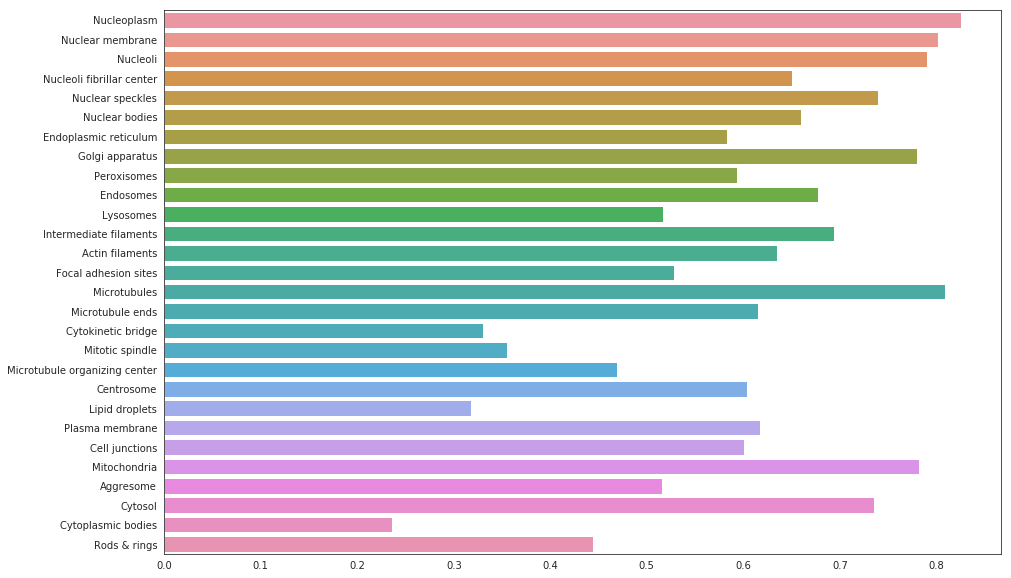

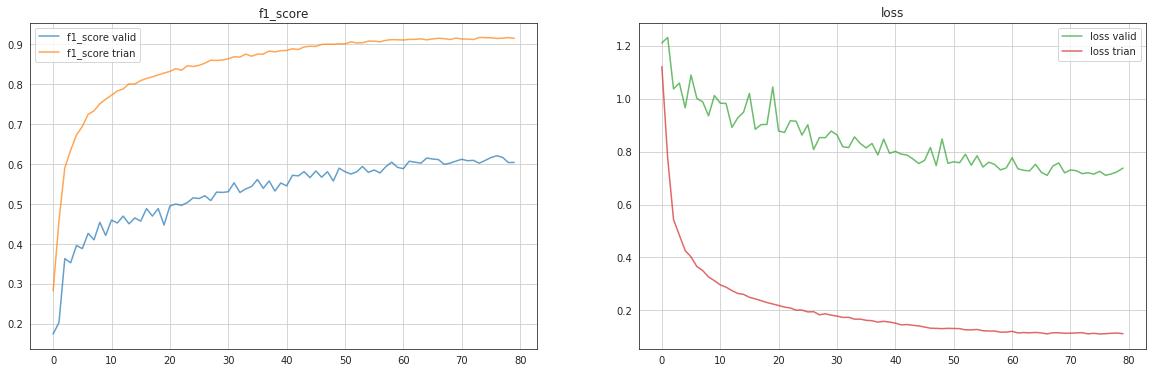

Overlapped keys: 727


  0%|          | 0/19058 [00:00<?, ?it/s]

int() argument must be a string, a bytes-like object or a number, not 'NoneType'
idx: 0
shape '[8, 5, 28]' is invalid for input of size 224
idx: 0


In [22]:
for fold in range(3, 4):# config.PARAMS['NB_FOLDS']):
    orchestrate_inference(fold, checkpoints_pth, epoch)

In [ ]:
dump_path = os.path.join(checkpoints_pth, '{}_fold_{}')
template_path = 'fold_{}_checkpoint.epoch_{}'
path = os.path.join(checkpoints_pth, template_path)


valid_predicts = list()
valid_labels = list()
for fold in range(1): #config.PARAMS['NB_FOLDS']):
    valid_predicts.append(np.load(dump_path.format('valid_predicts', fold) + '.npy'))
    valid_labels.append(np.load(dump_path.format('valid_labels', fold) + '.npy'))
valid_predicts = np.concatenate(valid_predicts)
valid_labels = np.concatenate(valid_labels)


predicts = list()
for fold in range(1): #config.PARAMS['NB_FOLDS']):
    predicts.append(np.load(dump_path.format('test_predicts', fold) + '.npy'))
predicts = np.stack(predicts)


In [ ]:
def get_threshold(roc_curve):
    vec = np.ones(shape=(2, ))
    vec /= np.linalg.norm(vec, ord=2)
    pts = vec.reshape(2, 1) * np.dot(vec, roc_curve[:2])
    distances = np.linalg.norm(roc_curve[:2] - pts, ord=2, axis=0)
    idx = np.argmax(distances)
    return roc_curve[-1, idx], idx

In [27]:
labels_ = valid_labels
preds_ = valid_predicts.max(1)

# labels_ = history['valid_losses'][epoch]['labels'] # np.concatenate([stamp['labels'] for stamp in history['valid_losses']])
# preds_ = history['valid_losses'][epoch]['predictions'] # np.concatenate([stamp['predictions'] for stamp in history['valid_losses']])

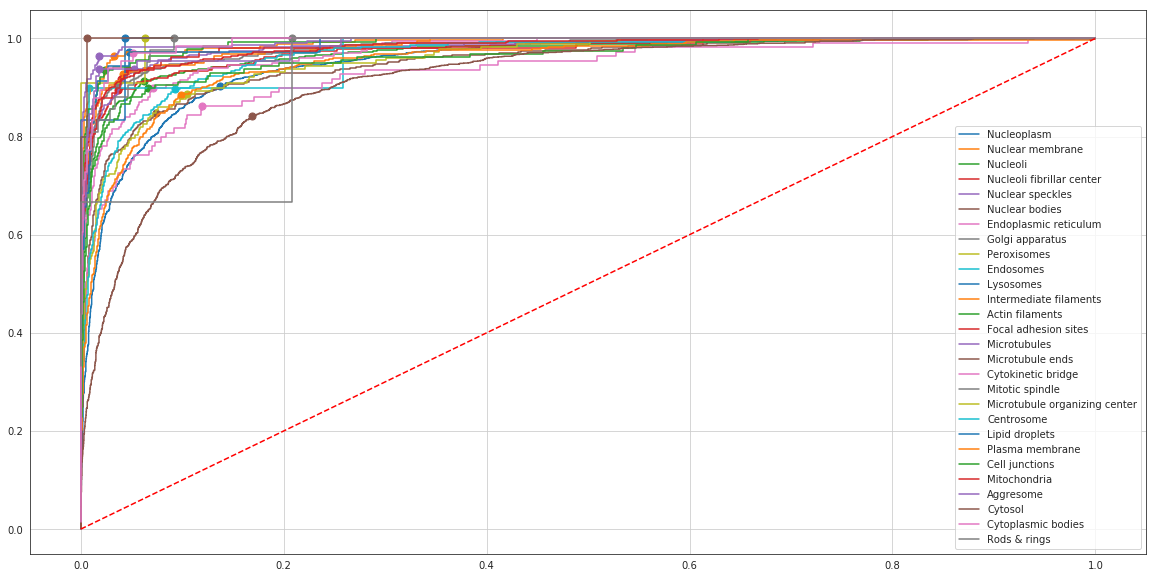

In [28]:
threshs = dict()
plt.figure(figsize=(20, 10))
for i in range(labels_.shape[-1]):
    roc_curve = sklearn.metrics.roc_curve(labels_[:, i], preds_[:, i])
    roc_curve = np.array(roc_curve)
    threshs[i], idx = get_threshold(roc_curve)
    plt.plot(roc_curve[0], roc_curve[1], label=label_names[i])
    plt.scatter(roc_curve[0, idx], roc_curve[1, idx], marker='o', s=50)

plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), 'r--')
plt.legend()
plt.grid()
plt.show()

threshs = np.array([threshs[i] for i, el in enumerate(label_names_list)])

/home/vessemer/anaconda3/envs/cxr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


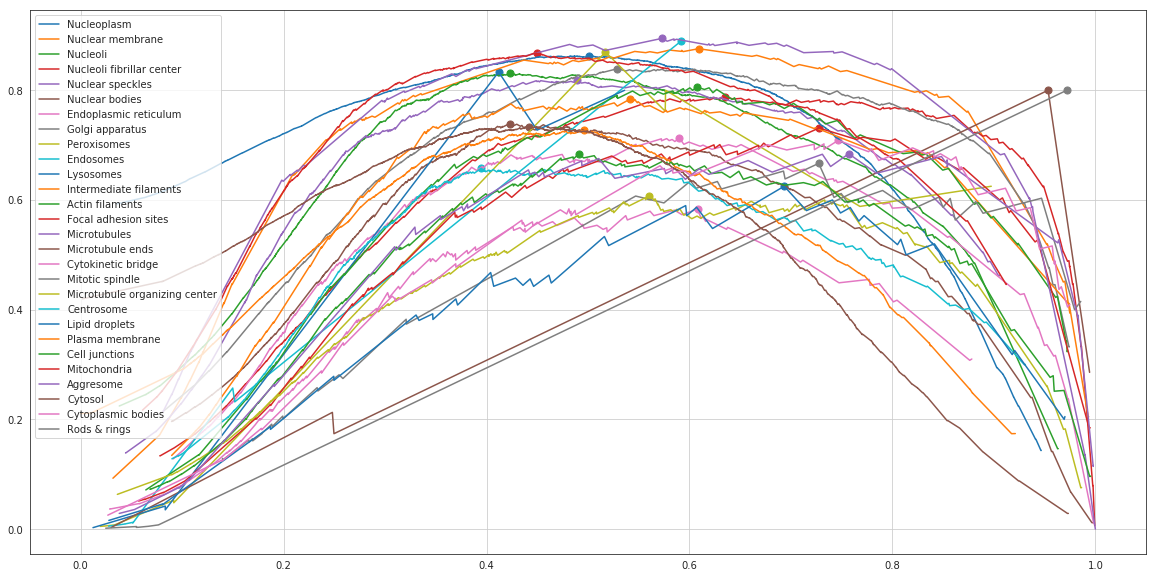

In [29]:
threshs = dict()
plt.figure(figsize=(20, 10))
for i in range(labels_.shape[-1]):
    roc_curve = sklearn.metrics.roc_curve(labels_[:, i], preds_[:, i])
    roc_curve = np.array(roc_curve)
    f1_scores = [sklearn.metrics.f1_score(labels_[:, i], preds_[:, i] >= t) for t in roc_curve[-1]]
    idx = np.argmax(f1_scores)
    threshs[i] = roc_curve[-1][idx]
    plt.plot(roc_curve[-1][1:-1], f1_scores[1:-1], label=label_names[i])
    plt.scatter(roc_curve[-1, idx], f1_scores[idx], marker='o', s=50)

plt.legend()
plt.grid()
plt.show()

threshs = np.array([threshs[i] for i, el in enumerate(label_names_list)])

In [30]:
folds = ds.get_folds(config.PARAMS['NB_FOLDS'])
_, valid_dataset = ds.get_datasets(folds, fold)

test_dataset = ds.ProteinDataset(
    test_df, 
    config.PATHS['TEST'], 
    config.label_names_list, 
    augmentations=None
)

In [31]:
history = pickle.load(open(path.format(fold, 'loss'), 'rb'))

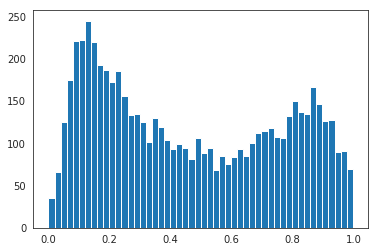

In [32]:
plt.hist(preds_[:, 0], 50);

In [33]:
np.mean(measure_f1(preds_, labels_, threshs=.5))

0.7080549964052435

In [34]:
np.mean(measure_f1(preds_, labels_, threshs=threshs))

0.7376374193131517

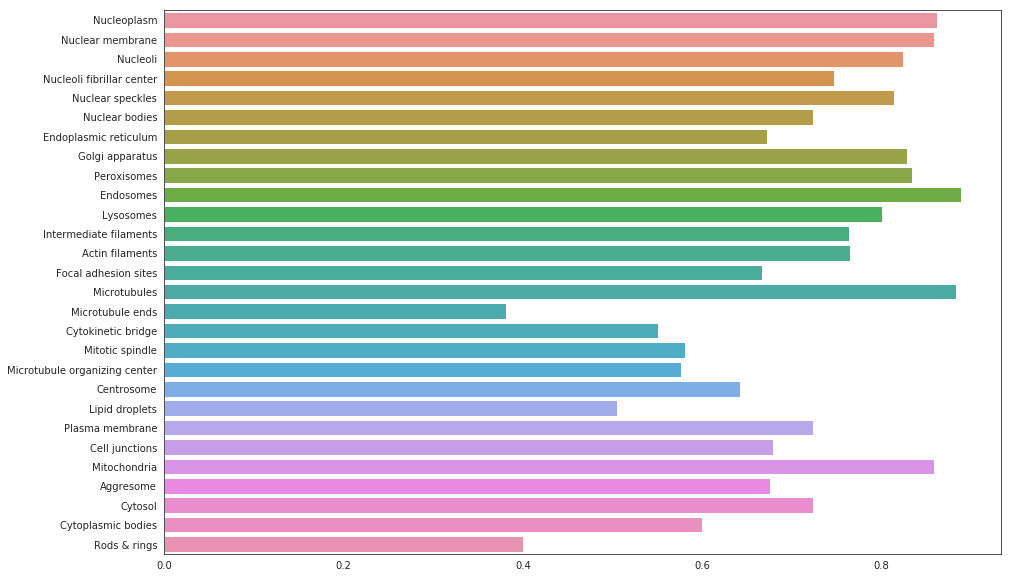

In [35]:
plt.figure(figsize=(15,10))
sns.barplot(y=config.label_names_list, x=measure_f1(preds_, labels_));
plt.show()

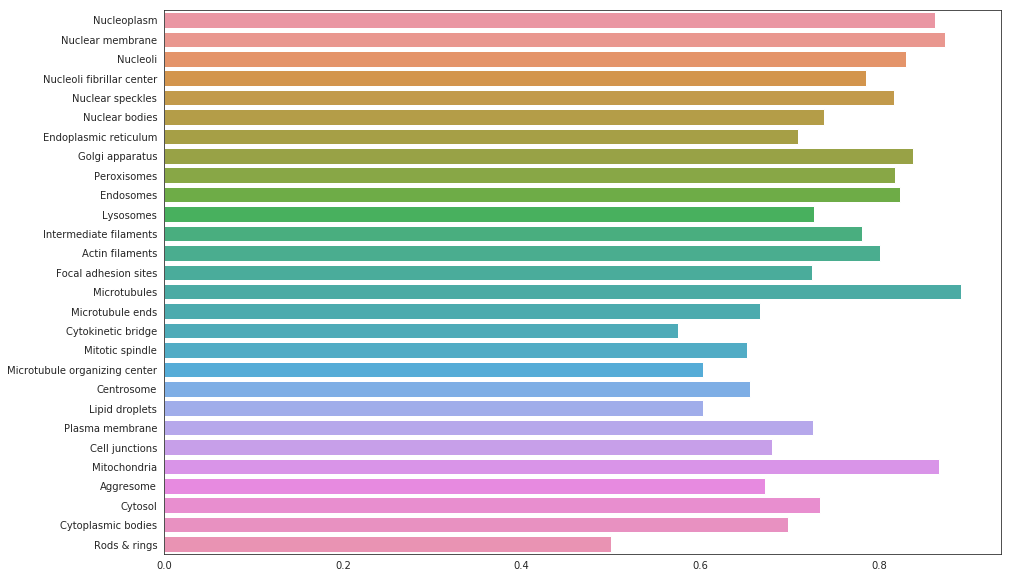

In [36]:
plt.figure(figsize=(15,10))
sns.barplot(y=config.label_names_list, x=measure_f1(preds_, labels_, threshs=threshs));
plt.show()

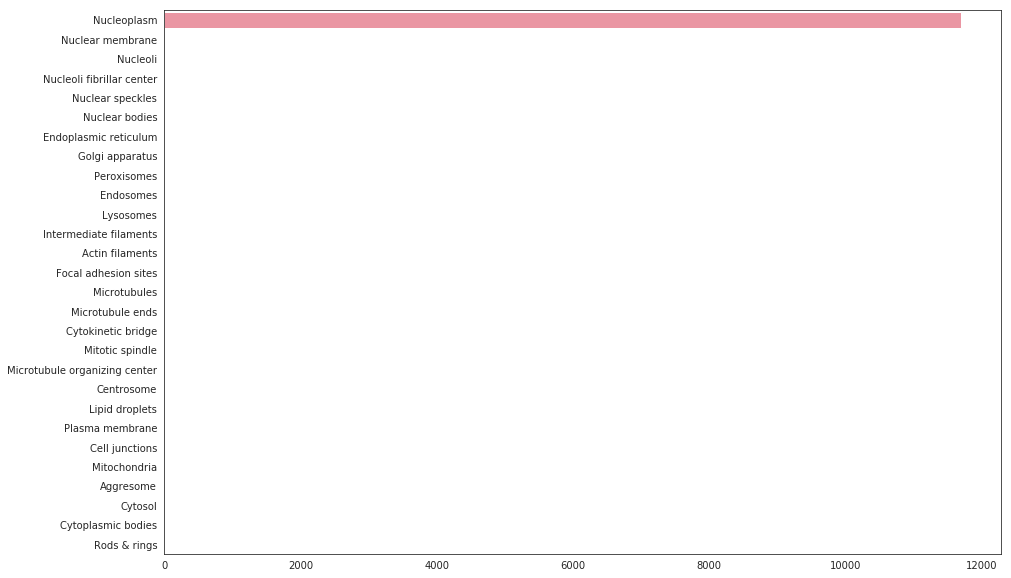

In [37]:
threshold = threshs # .5
predictions = predicts.max(2).mean(0) # format_predictions(results)['predictions']


selected = predictions > threshold
idxs_mask = ~np.any(selected, axis=1)
best_outs = np.argmax(predictions[idxs_mask], axis=1)
selected[idxs_mask, best_outs] = True
counts = np.zeros(shape=(len(config.label_names_list, )))
counts[:max(best_outs) + 1] = np.bincount(best_outs)

plt.figure(figsize=(15, 10))
sns.barplot(y=config.label_names_list, x=counts);
plt.show()

idxs = np.array(np.where(selected))
groups = npi.group_by(idxs[0]).split(idxs[1])

In [38]:
for idx, el in tqdm(zip(np.unique(idxs[0]), groups)):
    # test_datagen.dataset.labels.loc[idx, [label_names[e] for e in el]] = predictions[idx, el]
    test_dataset.labels.loc[idx, 'Predicted'] = ' '.join(['%d' % e for e in el])

11702it [00:16, 713.18it/s]


In [39]:
test_dataset.labels['Id'] = test_dataset.labels.index
df = test_dataset.labels[['Id', 'Predicted']]
df.to_csv('simple.csv', index=False)

In [40]:
df[df.Predicted.isna()].shape

(0, 2)